In [ ]:
!pip install pytorch-tabnet

In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import scipy

import os
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"
PATH = os.path.dirname(os.getcwd())

In [7]:
train = pd.read_csv(os.path.join(PATH, r"data/train.csv"))
test = pd.read_csv(os.path.join(PATH, r"data/test.csv"))

In [8]:
train['Внесена предоплата'] = train['Внесена предоплата'].astype('float64')
test['Внесена предоплата'] = test['Внесена предоплата'].astype('float64')

In [9]:
train['Внесена предоплата'] = train['Внесена предоплата'].astype('float64')
test['Внесена предоплата'] = test['Внесена предоплата'].astype('float64')

weather_code_cols = [col for col in train.columns if 'weather_code' in col]
train[weather_code_cols] = train[weather_code_cols].astype('int32')
test[weather_code_cols] = test[weather_code_cols].astype('int32')

In [10]:
df = pd.concat([train, test], axis=0)

In [11]:
# label encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes('object').columns
#cat_dims = {}
for col in cat_cols:
    encoder = LabelEncoder()
    encoder.fit(df[col])
    train[col] = encoder.transform(train[col])
    test[col] = encoder.transform(test[col])
    #cat_dims[col] = len(encoder.classes_)
    
target = 'target'

In [13]:
tabnet_params = {"cat_emb_dim":10,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=3e-2),
                 "scheduler_params":{"step_size":50,
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

D:\conda\envs\new_env\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train[features], train['target'])

X_train, X_test = X_train.values, X_test.values
y_train, y_test = y_train.values, y_test.values

In [15]:
from pytorch_tabnet.augmentations import ClassificationSMOTE # дополнительная аугментация через SMOTE

aug = ClassificationSMOTE(p=0.2)
max_epochs = 50 if not os.getenv("CI", False) else 2

In [16]:
# Fitting the model without starting from a warm start but with the computing of the feature importance activated

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug, #aug, None
    compute_importance=True # True by default so not needed
)


epoch 0  | loss: 0.7264  | train_auc: 0.48216 | valid_auc: 0.48076 |  0:00:02s
epoch 1  | loss: 0.61261 | train_auc: 0.51246 | valid_auc: 0.49698 |  0:00:04s
epoch 2  | loss: 0.54931 | train_auc: 0.54764 | valid_auc: 0.54155 |  0:00:06s
epoch 3  | loss: 0.53484 | train_auc: 0.61811 | valid_auc: 0.61811 |  0:00:08s
epoch 4  | loss: 0.53343 | train_auc: 0.74501 | valid_auc: 0.73739 |  0:00:10s
epoch 5  | loss: 0.52843 | train_auc: 0.70572 | valid_auc: 0.69583 |  0:00:12s
epoch 6  | loss: 0.51988 | train_auc: 0.70367 | valid_auc: 0.70139 |  0:00:14s
epoch 7  | loss: 0.52232 | train_auc: 0.77165 | valid_auc: 0.74864 |  0:00:16s
epoch 8  | loss: 0.51193 | train_auc: 0.76972 | valid_auc: 0.75293 |  0:00:18s
epoch 9  | loss: 0.50156 | train_auc: 0.74585 | valid_auc: 0.7251  |  0:00:20s
epoch 10 | loss: 0.49802 | train_auc: 0.77767 | valid_auc: 0.75865 |  0:00:22s
epoch 11 | loss: 0.49977 | train_auc: 0.75589 | valid_auc: 0.73406 |  0:00:24s
epoch 12 | loss: 0.49675 | train_auc: 0.80623 | vali

D:\conda\envs\new_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


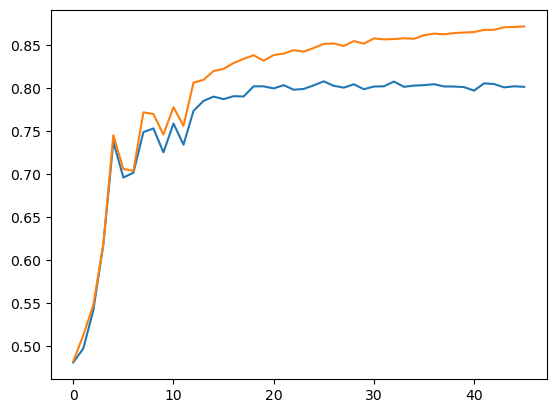

In [17]:
plt.plot(clf.history['valid_auc'])
plt.plot(clf.history['train_auc']);

In [18]:
predictions = clf.predict_proba(test[features].values)

In [ ]:
pd.Series(predictions).to_csv('Tabnet_base.csv', index = False)

## OOF Predictions

In [ ]:
from sklearn.model_selection import KFold
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)


n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds = np.zeros(train.shape[0])
models = []

for train_idx, val_idx in kf.split(train[features]):
    X_train, y_train = train.loc[train_idx, features].values, train.loc[train_idx, 'target'].values
    X_val, y_val = train.loc[val_idx, features].values, train.loc[val_idx, 'target'].values

    tabnet_params = {#"cat_idxs":cat_idxs,
                     #"cat_dims":cat_dims,
                     "cat_emb_dim":2,
                     "optimizer_fn":torch.optim.Adam,
                     "optimizer_params":dict(lr=2e-2),
                     "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                     "gamma":0.9},
                     "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                     "mask_type":'entmax', # "sparsemax"
                     #"grouped_features" : grouped_features
                    }

    clf = TabNetClassifier(**tabnet_params
                          )
    clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=100 , patience=30,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug, #aug, None
    compute_importance=True # True by default so not needed
    )
    
    models.append(clf)
    
    oof_preds[val_idx] += clf.predict_proba(X_val)[:, 1]

In [ ]:
pd.Series(oof_preds).to_csv('oof_preds_tabnet.csv', index = False)

In [ ]:
predictions = np.zeros((test.shape[0], 2))
for model in models:
    predictions += model.predict_proba(test[features].values)

predictions /= 5
final_predictions = np.zeros((test.shape[0]))
final_predictions[predictions[:,1] > 0.5] = 1

In [ ]:
pd.Series(final_predictions).to_csv('tabnet_oof.csv', index = False, header = False)

In [ ]:
pd.Series(predictions[:,1]).to_csv('tabnet_final_stacking.csv', index = False, header = False)